# Install and import dependencies

In [211]:
%%capture
!pip install opencv-python matplotlib imageio gdown tensorflow

In [212]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

# Build data loading functions

In [213]:
import gdown

In [215]:
%%capture
# Download the zip file containing the data from Google Drive using its ID
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
# Use gdown library to download the file from the URL and save it to output file
gdown.download(url,output,quiet=False)
gdown.extractall('data.zip')

In [216]:
#This function loads a video from a given path and preprocesses the frames. The function returns a list of preprocessed frames.
def load_video(path:str) -> List[float]: 
    
    # Open the video file
    cap = cv2.VideoCapture(path)
    
    # Initialize an empty list to store preprocessed frames
    frames = []
    
    # Iterate through each frame in the video
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        
        # Convert the frame to grayscale
        frame = tf.image.rgb_to_grayscale(frame)
        
        # Crop the frame to focus only on the lips and append the preprocessed frame to the list
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    # Calculate the mean and standard deviation of the frames
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    
    # Normalize the frames by subtracting the mean and dividing by the standard deviation
    return tf.cast((frames - mean), tf.float32) / std


In [217]:
#list of major alphabets, numbers and special characters  
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]


In [218]:
#Create a StringLookup layer to map characters to integers
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
#Create a StringLookup layer to map integers back to characters
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

#Print the vocabulary size and content of the StringLookup layer
print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [219]:
char_to_num(['s','k','a','t','y'])

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([19, 11,  1, 20, 25])>

In [220]:
num_to_char([19, 11,  1, 20, 25])

<tf.Tensor: shape=(5,), dtype=string, numpy=array([b's', b'k', b'a', b't', b'y'], dtype=object)>

In [221]:
# Define a function to load alignments from a given path
def load_alignments(path:str) -> List[str]: 
    # Open the file in read mode and get all the lines
    with open(path, 'r') as f: 
        lines = f.readlines() 
        
    # Initialize an empty list to hold the tokens    
    tokens = []
    
    # Loop through each line in the file
    for line in lines:
        line = line.split() # Split the line into a list of words
        if line[2] != 'sil': # If the third word in the line is not 'sil'
            tokens = [*tokens,' ',line[2]] # Append a space and the third word to the tokens list
            
    # Split the tokens into individual characters, convert them to numerical values using char_to_num, and return the result
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [222]:
def load_data(path: str): 
    # Decode path from bytes to string
    path = bytes.decode(path.numpy())
    # Get the file name from the path and remove the file extension
    file_name = path.split('/')[-1].split('.')[0]
    # Build paths to video and alignment files
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    # Load video frames and text alignments
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [223]:
test_path = './data/s1/bbal6n.mpg'

In [224]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbal6n'

In [225]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

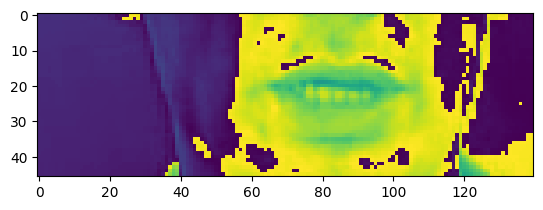

In [226]:
plt.imshow(frames[28])

In [227]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [228]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()]).numpy().decode('utf-8')

'bin blue at l six now'

In [229]:
def mappable_function(path:str) ->List[str]:
    # Call the load_data function using TensorFlow's py_function, which can be used to wrap Python functions 
    # and make them usable inside a TensorFlow graph. 
    # This allows us to load and preprocess data in parallel with TensorFlow's data pipeline.
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    # Return the loaded and preprocessed data
    return result

# Create data pipeline

In [230]:
# Get list of file paths for all videos
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
# Shuffle the order of the videos
data = data.shuffle(500, reshuffle_each_iteration=False)
# Map the load_data function to each file path and get frames and alignments
data = data.map(mappable_function)
# Padded batch of 2 videos, with frames padded to 75 frames and alignments padded to 40 characters
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
# Prefetch to optimize for performance
data = data.prefetch(tf.data.AUTOTUNE)
# Split the data into train and test sets
train = data.take(450)
test = data.skip(450)

In [231]:
len(test)


50

In [232]:
frames, alignments = data.as_numpy_iterator().next()


In [233]:
len(frames)


2

In [234]:
sample = data.as_numpy_iterator()


In [235]:
%%capture
val = sample.next(); val[0]


In [236]:
%%capture
#This code saves a gif animation from the frames of a video.
imageio.mimsave('./animation.gif', val[0][0], fps=10)

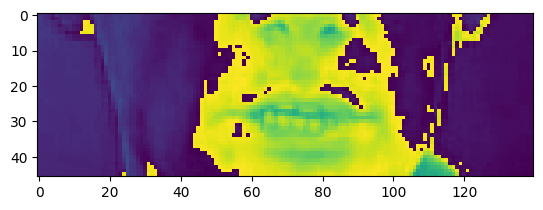

In [237]:
plt.imshow(val[0][0][35])


In [238]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])


<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at m four please'>

# Design the deep neural network

In [239]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [240]:
data.as_numpy_iterator().next()[0][0].shape


(75, 46, 140, 1)

In [241]:
model = Sequential()
#Add a Conv3D layer with 128 filters, kernel size of 3, and padding of 'same', with input shape of (75,46,140,1)
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
#Add a MaxPool3D layer with pool size of (1,2,2)
model.add(MaxPool3D((1,2,2)))

#Add another Conv3D layer with 256 filters, kernel size of 3, and padding of 'same'
model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

#Add another Conv3D layer with 75 filters, kernel size of 3, and padding of 'same'
model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

#Add a TimeDistributed layer with Flatten
model.add(TimeDistributed(Flatten()))

#Add a Bidirectional LSTM layer with 128 units, orthogonal kernel initializer, and return_sequences=True
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

#Use a He normal initializer and softmax activation
model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [242]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 75, 46, 140, 128)  3584      
                                                                 
 activation_15 (Activation)  (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d_15 (MaxPoolin  (None, 75, 23, 70, 128)  0         
 g3D)                                                            
                                                                 
 conv3d_16 (Conv3D)          (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_16 (Activation)  (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 75, 11, 35, 256)  0         
 g3D)                                                 

In [243]:
yhat = model.predict(val[0])


1/1 [==============================] - 8s 8s/step


In [244]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])


<tf.Tensor: shape=(), dtype=string, numpy=b'rr  88888888888888888888888888888888888888888888888                  pppppl'>

In [245]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])


<tf.Tensor: shape=(), dtype=string, numpy=b'rr  88888888888888888888888888888888888888888888888                  pppppl'>

# Setup training options and train

In [246]:
#This function defines a learning rate scheduler that decays the learning rate exponentially
#after the 30th epoch. The scheduler function takes the epoch number and the current learning rate
#as inputs and returns the new learning rate to be used for the next epoch.

def scheduler(epoch, lr):
    #If the epoch is less than 30, the current learning rate is returned without any modification.
    if epoch < 30:
        return lr
    else:
        #After the 30th epoch, the learning rate is multiplied by e^(-0.1) for every subsequent epoch.
        return lr * tf.math.exp(-0.1)

In [247]:
#This function computes the Connectionist Temporal Classification (CTC) loss between the predicted labels and true labels.
#It takes two inputs, y_true and y_pred, which are the true and predicted labels respectively.

def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    # Create tensors of shape (batch_size, 1) with the input and label lengths
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    
    # Compute the CTC loss using the backend function ctc_batch_cost
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [248]:
#Define a callback class named ProduceExample which extends tf.keras.callbacks.Callback
class ProduceExample(tf.keras.callbacks.Callback): 
    # Constructor of the callback class, which takes in a dataset as input and initializes it
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    # Callback function which is called at the end of each epoch
    def on_epoch_end(self, epoch, logs=None) -> None:
        # Get the next batch of data from the dataset iterator
        data = self.dataset.next()
        # Predict the output for the current batch using the model
        yhat = self.model.predict(data[0])
        # Decode the predicted output using CTC decoding
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        # Iterate over each item in the batch
        for x in range(len(yhat)):
            # Print the original label of the item
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            # Print the predicted label of the item
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            # Print a line of dashes for better visualization
            print('~'*100)

In [249]:
#The following code compiles the model with the Adam optimizer and sets the learning rate to 0.0001.
#It also sets the loss function to CTCLoss.
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)


In [250]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 


In [251]:
schedule_callback = LearningRateScheduler(scheduler)


In [252]:
example_callback = ProduceExample(test)


In [253]:
#model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])


# Make a prediction

In [254]:
# URL to the zip file containing checkpoints
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
# Name of the output zip file
output = 'checkpoints.zip'
# Download the zip file from Google Drive
gdown.download(url, output, quiet=False)
# Extract the contents of the zip file to the 'models' folder
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From: https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
To: /Users/sanjeev/Desktop/lipread/checkpoints.zip
100%|██████████████████████████████████████| 94.5M/94.5M [00:07<00:00, 12.3MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [255]:
#model.load_weights('models/checkpoint')


In [256]:
from tensorflow.keras.optimizers.legacy import Adam

# Create an instance of the same optimizer used during training
optimizer = Adam(lr=0.001)

# Compile the model with the same optimizer
model.compile(loss=CTCLoss, optimizer=optimizer)

# Load the saved weights
model.load_weights('models/checkpoint')


In [257]:
test_data = test.as_numpy_iterator()


In [258]:
sample = test_data.next()


[mpeg1video @ 0x7fa93491a080] ac-tex damaged at 22 17
[mpeg1video @ 0x7fa93491a080] Warning MVs not available


In [259]:
yhat = model.predict(sample[0])


1/1 [==============================] - 9s 9s/step


In [260]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay red at r two please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place red with d seven again'>]

In [261]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()


In [262]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay red at r two please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place red with d seven again'>]

# Test on a video

In [263]:
sample = load_data(tf.convert_to_tensor('./data/s1/bbaf3s.mpg'))


In [264]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f three soon'>]

In [265]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))


1/1 [==============================] - 4s 4s/step


In [266]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()


In [267]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at j three soon'>]